In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Add Bayesian-and-novelty directory to the PYTHONPATH
import sys
import os
sys.path.append(os.path.realpath('../../..'))

# Autoreload changes in utils, etc.
%load_ext autoreload
%autoreload 2

from novelty.utils.metrics import plot_roc, plot_prc
from novelty.utils.metrics import get_summary_statistics
from novelty.utils.metrics import html_summary_table

In [2]:
# Training settings
BATCH_SIZE = 128
NO_CUDA = False
SEED = 1
CLASSES = 10
MODEL_PATH_ROOT = './weights/mnist_resize/model_epoch_100'
MODEL_PATH = MODEL_PATH_ROOT + '.pth'

# mean and stdevs of training data by channel
CHANNEL_MEANS = (33.3184589445591/255,33.3184589445591/255,33.3184589445591/255)
CHANNEL_STDS = (78.56747969985008/255,78.56747969985008/255,78.56747969985008/255)

# Plot ROC and PR curves
PLOT_CHARTS = True

## Initialize model and load MNIST

In [3]:
from novelty.utils import DATA_DIR

torch.manual_seed(SEED)

use_cuda = not NO_CUDA and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Dataset transformation
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.expand(3, -1, -1)) # Expand to 3 channels to work with VGG model
])

# Load training and test sets
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root=os.path.join(DATA_DIR, 'mnist'), train=True, download=True, transform=transform),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
datasets.MNIST(root=os.path.join(DATA_DIR, 'mnist'), train=False, download=True, transform=transform),
    batch_size=BATCH_SIZE, shuffle=False, **kwargs)

In [4]:
import models

# Create model instance
model = models.vgg13(num_classes=CLASSES)
model = model.to(device)

model.load_state_dict(torch.load(MODEL_PATH))

## Prediction functions

In [5]:
from torch.autograd import Variable

def predict(model, data, device):
    model.eval()
    data = data.to(device)
    outputs = model(data)
    outputs = outputs - outputs.max(1)[0].unsqueeze(1)  # For stability
    return F.softmax(outputs, dim=1)

In [6]:
def get_max_model_outputs(data_loader, device):
    """Get the max softmax output from the model in a Python array.

    data_loader: object
        A pytorch dataloader with the data you want to calculate values for.

    device: object
        The CUDA device handle.
    """
    result = []
    
    for data, target in data_loader:
        # Using regular model
        p = predict(model, data, device)
        max_val, label = torch.max(p, dim=1)
        # Convert torch tensors to python list
        max_val = list(max_val.cpu().detach().numpy())
        result += max_val

    return result

In [7]:
import pandas as pd

# Build results table
results = {
    "vgg13": {
        "inlier_name": "MNIST10",
        "outliers": {}
    }
}

df = pd.DataFrame(columns=['auroc', 'aupr_in', 'aupr_out', 'fpr_at_95_tpr', 'detection_error'])

### Process Inliers

In [8]:
num_inliers = test_loader.dataset.test_data.shape[0]

# Get predictions on in-distribution images
mnist_model_maximums = get_max_model_outputs(test_loader, device)

### Fashion MNIST

In [9]:
directory = os.path.join(DATA_DIR, 'fashion_mnist')

# Dataset transformation
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.expand(3, -1, -1)) # Expand to 3 channels to work with VGG model
])

# Load the dataset
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
fashion_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(directory, train=False, transform=transform, download=True),
        batch_size=BATCH_SIZE, shuffle=True, **kwargs)

num_fashion = len(fashion_loader.dataset)

# Get predictions on in-distribution images
fashion_model_maximums = get_max_model_outputs(fashion_loader, device)

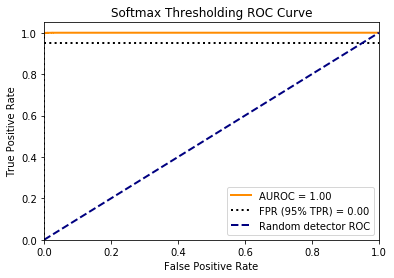

In [10]:
labels = [1] * num_inliers + [0] * num_fashion
predictions = mnist_model_maximums + fashion_model_maximums

stats = get_summary_statistics(predictions, labels)
results["vgg13"]["outliers"]["Fashion"] = stats
df.loc['fashion'] = pd.Series(stats)

if PLOT_CHARTS:
    plot_roc(predictions, labels, title="Softmax Thresholding ROC Curve")

### EMNIST Letters

In [11]:
directory = os.path.join(DATA_DIR, 'emnist')

# Dataset transformation
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.expand(3, -1, -1)) # Expand to 3 channels to work with VGG model
])

# Load the dataset
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
emnist_loader = torch.utils.data.DataLoader(
        datasets.EMNIST(directory, "letters", train=False, transform=transform, download=True),
        batch_size=BATCH_SIZE, shuffle=True, **kwargs)

num_emnist = len(emnist_loader.dataset)

# Get predictions on in-distribution images
emnist_model_maximums = get_max_model_outputs(emnist_loader, device)

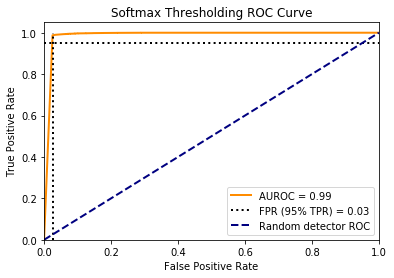

In [12]:
labels = [1] * num_inliers + [0] * num_emnist
predictions = mnist_model_maximums + emnist_model_maximums

stats = get_summary_statistics(predictions, labels)
results["vgg13"]["outliers"]["EMNIST Letters"] = stats
df.loc['letters'] = pd.Series(stats)

if PLOT_CHARTS:
    plot_roc(predictions, labels, title="Softmax Thresholding ROC Curve")

### Not MNIST

In [13]:
directory = os.path.join(DATA_DIR, 'notmnist/notMNIST_small')

# Dataset transformation
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.expand(3, -1, -1)) # Expand to 3 channels to work with VGG model
])

# Load the dataset
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
notmnist_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(directory, transform=transform),
        batch_size=BATCH_SIZE, shuffle=True, **kwargs)

num_notmnist = len(notmnist_loader.dataset)

# Get predictions on in-distribution images
notmnist_model_maximums = get_max_model_outputs(notmnist_loader, device)

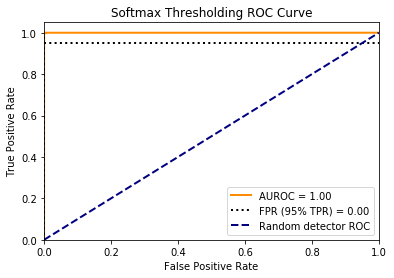

In [14]:
labels = [1] * num_inliers + [0] * num_notmnist
predictions = mnist_model_maximums + notmnist_model_maximums

stats = get_summary_statistics(predictions, labels)
results["vgg13"]["outliers"]["Not MNIST"] = stats
df.loc['not_mnist'] = pd.Series(stats)

if PLOT_CHARTS:
    plot_roc(predictions, labels, title="Softmax Thresholding ROC Curve")

### Rotated 90 MNIST

In [15]:
directory = os.path.join(DATA_DIR, 'mnist')

# Dataset transformation
transform = transforms.Compose([
    transforms.Lambda(lambda image: image.rotate(90)),
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.expand(3, -1, -1)) # Expand to 3 channels to work with VGG model
])

# Load the dataset
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
rot90_loader = torch.utils.data.DataLoader(
        datasets.MNIST(directory, train=False, transform=transform, download=True),
        batch_size=BATCH_SIZE, shuffle=True, **kwargs)

num_rot90 = len(rot90_loader.dataset)

# Get predictions on in-distribution images
rot90_model_maximums = get_max_model_outputs(rot90_loader, device)

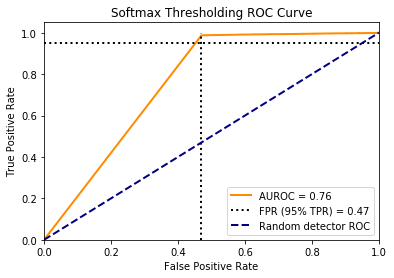

In [16]:
labels = [1] * num_inliers + [0] * num_rot90
predictions = mnist_model_maximums + rot90_model_maximums

stats = get_summary_statistics(predictions, labels)
results["vgg13"]["outliers"]["MNIST rot90"] = stats
df.loc['rot90'] = pd.Series(stats)

if PLOT_CHARTS:
    plot_roc(predictions, labels, title="Softmax Thresholding ROC Curve")

### Gaussian Noise Dataset

In [17]:
from novelty.utils.datasets import GaussianNoiseDataset

class InvertNormalize(object):
    """Undoes the operation performed using transforms.Normalize using the same MEAN and STD arrays."""
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be inverse normalized.

        Returns:
            Tensor: Normalized Tensor image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


gaussian_transform = transforms.Compose([
    #TODO clip to [0,1] range
    transforms.ToTensor(),
    InvertNormalize(CHANNEL_MEANS, CHANNEL_STDS)
])

kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
gaussian_loader = torch.utils.data.DataLoader(
    GaussianNoiseDataset((10000, 32, 32, 3), mean=0., std=1., transform=gaussian_transform),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)

num_gaussian = len(gaussian_loader.dataset)

# Get predictions on in-distribution images
gaussian_model_maximums = get_max_model_outputs(gaussian_loader, device)

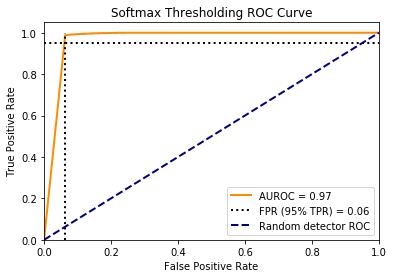

In [18]:
labels = [1] * num_inliers + [0] * num_gaussian
predictions = mnist_model_maximums + gaussian_model_maximums

stats = get_summary_statistics(predictions, labels)
results["vgg13"]["outliers"]["Gaussian Noise"] = stats
df.loc['gaussian'] = pd.Series(stats)

if PLOT_CHARTS:
    plot_roc(predictions, labels, title="Softmax Thresholding ROC Curve")

### Uniform Noise Dataset

In [19]:
from novelty.utils.datasets import UniformNoiseDataset
import math

uniform_transform = transforms.Compose([
    #TODO clip to [0,1] range
    transforms.ToTensor(),
    InvertNormalize(CHANNEL_MEANS, CHANNEL_STDS)
])

kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
uniform_loader = torch.utils.data.DataLoader(
    UniformNoiseDataset((10000, 32, 32, 3), low=-math.sqrt(3.), high=math.sqrt(3.), transform=uniform_transform),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)

num_uniform = len(uniform_loader.dataset)

# Get predictions on in-distribution images
uniform_model_maximums = get_max_model_outputs(uniform_loader, device)

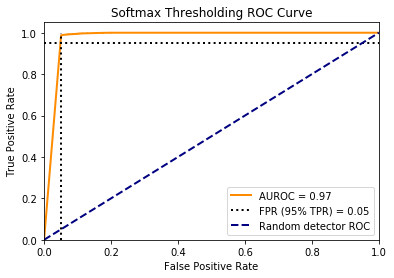

In [20]:
labels = [1] * num_inliers + [0] * num_uniform
predictions = mnist_model_maximums + uniform_model_maximums

stats = get_summary_statistics(predictions, labels)
results["vgg13"]["outliers"]["Uniform Noise"] = stats
df.loc['uniform'] = pd.Series(stats)

if PLOT_CHARTS:
    plot_roc(predictions, labels, title="Softmax Thresholding ROC Curve")

# Show Results Table

In [21]:
from IPython.display import HTML, display

table = html_summary_table(results)
display(HTML(table))

In [22]:
df.to_pickle('./results/mnist10_lee2018.pkl')
df

,auroc,aupr_in,aupr_out,fpr_at_95_tpr,detection_error
fashion,0.999935,0.999960,0.999933,0.000000,0.006200
letters,0.986425,0.973274,0.995397,0.025240,0.018820
not_mnist,0.999890,0.999853,0.999951,0.000107,0.006253
rot90,0.758656,0.835509,0.860879,0.470200,0.241300
gaussian,0.967362,0.969057,0.982994,0.063000,0.037700
uniform,0.973655,0.974725,0.986277,0.050800,0.031600
